# Анализ расходов на маркетинг Яндекс.Афиши 

## Общая информация об исследовании <a id="info"></a>

Цель исследования:

    Снижение расходов на маркетинг, перераспределение бюджета Яндекс.Афиши.
    
Исходные данные:
        
    Данные Яндекс.Афиши с июня 2017 по конец мая 2018 года

 - visits_log.csv - лог сервера с информацией о посещениях сайта, где
   - Uid — уникальный идентификатор пользователя,
   - Device — категория устройства пользователя,
   - Start Ts — дата и время начала сессии,
   - End Ts — дата и время окончания сессии,
   - Source Id — идентификатор источника перехода на сайт.<br><br>

 - orders_log.csv — информация о заказах, где
   - Uid — уникальный идентификатор пользователя,
   - Buy Ts — дата и время заказа,
   - Revenue — сумма заказа.<br><br>

 - costs.csv — информация о расходах на маркетинг, где
   - source_id — идентификатор рекламного источника,
   - dt — дата проведения рекламной кампании,
   - costs — расходы на эту кампанию.

 
 План работы:

- Изучение данных
- Предобработка данных
- Расчет и добавление данных
- Анализ и выявление зависимостей
- Выводы
    

In [1]:
# блок импорта библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math
import datetime as dt
import seaborn as sns

# количество отображаемых столбцов
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

## Изучение данных <a id="data"></a>

Загрузим предоставленные данные. Т.к. проект выполняется на локальной машине используем конструкцию try-except для того, чтобы данные загружались как локально, так и на Я.Практикуме

###  Таблица visits_log.csv

Для хранения данных из файла visits_log.csv создадим переменную visits.

In [2]:
# читаем таблицу visits_log.csv
try:
    visits = pd.read_csv('/datasets/visits_log.csv')
except:
    visits = pd.read_csv('visits_log.csv')

# смотрим результат  
visits.info()
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [3]:
# проверим на дубликаты
visits.duplicated().sum()

0

###  Таблица orders_log.csv

Для  данных из файла orders_log.csv создадим переменную orders.

In [4]:
# читаем таблицу orders_log.csv
try:
    orders = pd.read_csv('/datasets/orders_log.csv')
except:
    orders = pd.read_csv('orders_log.csv')

# смотрим результат  
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [5]:
# проверим на дубликаты
orders.duplicated().sum()

0

###  Таблица costs.csv

Для  данных из файла costs.csv создадим переменную costs.

In [6]:
# читаем таблицу costs.csv
try:
    costs = pd.read_csv('/datasets/costs.csv')
except:
    costs = pd.read_csv('costs.csv')
    
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [7]:
# проверим на дубликаты
costs.duplicated().sum()

0

#### Вывод

Как видим:
 
 - имена столбцов в таблицах `visits` и `orders` содержат заглавные буквы и пробелы;
 - пропусков нет;
 - дубликатов нет;
 - даты `End Ts`, `Start Ts`, `Buy Ts`  и `dt` хранятся в формате object. Необходимо преобразование в формат datetime.

## Предобработка данных

В этом разделе преобразуем имена столбцов и форматы дат. Проверим даты на соответствие заявленному периоду.

In [8]:
# приведем все знаки в наименованиях столбцов к нижнему регистру
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()

# заменит пробелы в именах столбцов на подчеркивание
visits.columns = visits.columns.str.replace('\s+', '_')
orders.columns = orders.columns.str.replace('\s+', '_')

In [9]:
# заменим формат дат во всех таблицах
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

# смотрим результаты
visits.info()
print()
orders.info()
print()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to

Проверим данные на соответствие заявленному периоду (с 1 июня 2017 по 31 мая 2018).

In [10]:
visits.query('start_ts<"2017-06-01 00:00:00"  or start_ts >"2018-05-31 23:59:00"')['uid'].count()

0

In [11]:
visits.query('end_ts<"2017-06-01 00:00:00"  or end_ts >"2018-05-31 23:59:00"')['uid'].count()

12

In [12]:
orders.query('buy_ts<"2017-06-01 00:00:00" or buy_ts >"2018-05-31 23:59:00"')['uid'].count()

1

In [13]:
costs.query('dt<"2017-06-01 00:00:00" or dt >"2018-05-31 23:59:00"')['source_id'].count()


0

В первых двух таблицах существуют записи не входящие в заявленый период (даты больше, чем 2018-05-31 23:59:59), которые необходимо отсечь.

In [14]:
# удаляем лишние строки по условию
visits = visits.query('end_ts < "2018-06-01 00:00:00"')
orders = orders.query('buy_ts < "2018-06-01 00:00:00"')

# проверяем результат
display(visits.query('end_ts<"2017-06-01 00:00:00"  or end_ts >"2018-05-31 23:59:00"')['uid'].count())
display(orders.query('buy_ts<"2017-06-01 00:00:00" or buy_ts >"2018-05-31 23:59:00"')['uid'].count())

0

0

Удалены 12 и 1 запись в таблицах визитов и заказов соответственно. 

#### Вывод

Наименования столбцов приведены к стандартному виду, преобразованы форматы полей с датами, отсечены данные не входящие в исследуемый период.

## Продуктовые метрики

### Расчет DAU, WAU и MAU

Для расчета количества уникальных пользователей в день, неделю и месяц выделим в отдельные столбцы год, месяц и неделю, а также полную дату визита.

In [15]:
visits_new = visits.copy()
visits_new['session_year']  = visits_new['start_ts'].dt.year
visits_new['session_month']  = visits_new['start_ts'].dt.month
visits_new['session_week']  = visits_new['start_ts'].dt.isocalendar().week
visits_new['session_date']  = visits_new['start_ts'].dt.date
# смотрим результат
visits_new.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


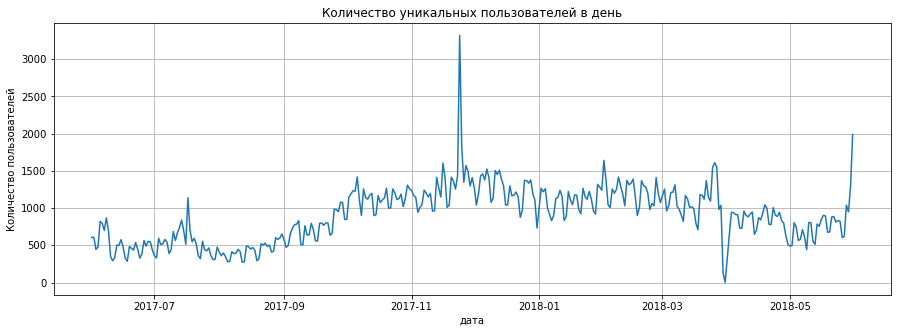

In [16]:
# рассчитаем количество уникальных пользователей в день
dau = visits_new.groupby(['session_year','session_date']).agg({'uid': 'nunique'}).reset_index()

# построим диаграмму количества уникальных пользователей по дням
dau_plot = dau.plot(x='session_date', 
                    y='uid', 
                    figsize=(15, 5),
                    grid=True, legend=None
                   )
dau_plot.set(title='Количество уникальных пользователей в день',
            xlabel = 'дата', ylabel='Количество пользователей')

plt.show()

посмотрим даты, в которые наблюдаются пиковые значения

In [17]:
dau_max_date = dau.query('uid > 2000')
print(dau_max_date)
dau_min_date = dau.query('uid < 200')
print(dau_min_date)

     session_year session_date   uid
176          2017   2017-11-24  3319
     session_year session_date  uid
302          2018   2018-03-30  131
303          2018   2018-03-31    1


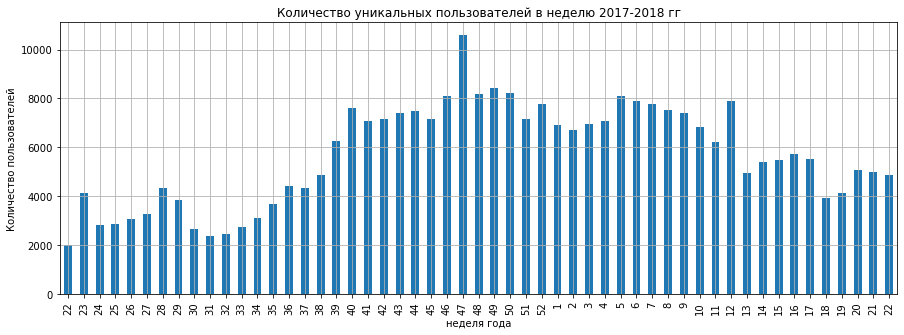

In [18]:
# рассчитаем количество уникальных пользователей в неделю
wau = visits_new.groupby(['session_year','session_week']).agg({'uid': 'nunique'}).reset_index()

# диаграмма количества уникальных пользователей по неделям

wau_plot = wau.plot(x='session_week', y='uid', kind='bar', figsize=(15, 5),
                 grid=True, legend=None
                 )

wau_plot.set(title='Количество уникальных пользователей в неделю 2017-2018 гг',
xlabel = 'неделя года', ylabel='Количество пользователей')
plt.show()

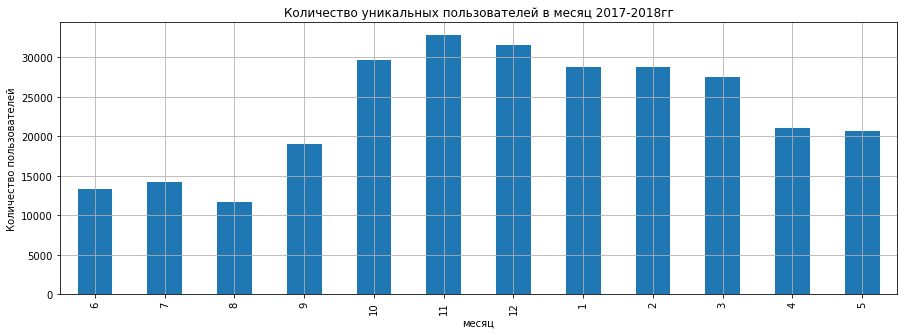

In [19]:
# рассчитаем количество уникальных пользователей в месяц
mau = visits_new.groupby(['session_year','session_month']).agg({'uid': 'nunique'}).reset_index()


# диаграмма количества уникальных пользователей по месяцам

mau_plot = mau.plot(x='session_month', y='uid', kind='bar', figsize=(15, 5),
                 grid=True, legend=None
                 )
mau_plot.set(title='Количество уникальных пользователей в месяц 2017-2018гг',
xlabel = 'месяц', ylabel='Количество пользователей')
plt.show()

Теперь рассчитаем средние значения этих метрик за весь период

In [20]:
dau_mean = visits_new.groupby('session_date').agg({'uid': 'nunique'}).mean()
print("Среднее количество уникальных пользователей в день (DAU):",int(dau_mean))

wau_mean = visits_new.groupby(['session_year','session_week']).agg({'uid': 'nunique'}).mean()
print("Среднее количество уникальных пользователей в неделю (WAU):",int(wau_mean))

mau_mean = visits_new.groupby(['session_year','session_month']).agg({'uid': 'nunique'}).mean()
print("Среднее количество уникальных пользователей в месяц (MAU):",int(mau_mean))

Среднее количество уникальных пользователей в день (DAU): 907
Среднее количество уникальных пользователей в неделю (WAU): 5716
Среднее количество уникальных пользователей в месяц (MAU): 23227


#### Вывод

Как видим из полученных трех графиков:
 - в осенне-летний период количество посетителей сайта в 1.5 - 2 раза ниже, в весенне-зимний;
 - имеется пик обращений на сайт 24 ноября 2017 года (3319). Возможно планировалось какое-то мероприятие или акция; 
 - имеется провал 30 и 31 марта 2018 г, вероятно связанный с недоступностью сервиса.
 
 
Среднее количество уникальных пользователей в день (DAU): 907<br>
Среднее количество уникальных пользователей в неделю (WAU): 5716<br>
Среднее количество уникальных пользователей в месяц (MAU): 23227

### Расчет среднего количества сессий одного пользователя в день

Определим, сколько раз в день в среднем пользователь заходит на сайт. Для этого количество сессий в день разделим на количество уникальных пользователей.

In [21]:
# расчет среднего количества входов на сайт в день одного пользователя
sessions_per_day = visits_new.groupby('session_date').agg({'uid': ['count', 'nunique']}).reset_index()
sessions_per_day.columns = ['session_date','n_sessions', 'n_users']
sessions_per_day['sessions_per_user'] = (
    sessions_per_day['n_sessions'] / sessions_per_day['n_users']
)
# смотрим результат
sessions_per_day.head(10)
# средняя величина количества входов на сайт в день одного пользователя за весь период
mean_session_per_user_total = sessions_per_day['sessions_per_user'].mean()
print('Среднее количество входов на сайт одного пользователя в день {:.2f} '.format(mean_session_per_user_total))


Среднее количество входов на сайт одного пользователя в день 1.08 


Для наглядности построим график изменения этой величины:

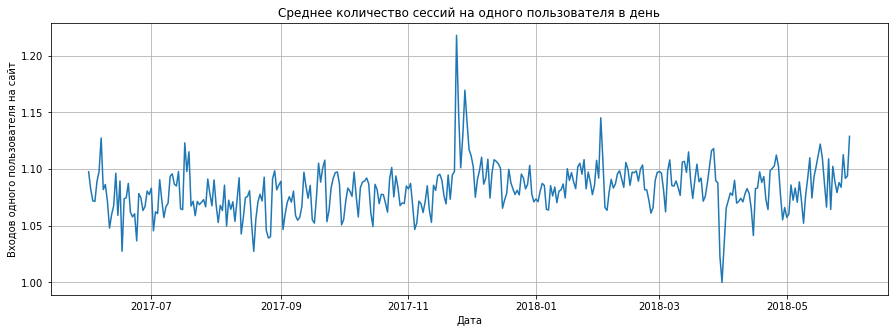

In [22]:
sessions_per_day_plot = sessions_per_day.plot(x='session_date', y='sessions_per_user',  figsize=(15, 5),
                 grid=True, legend=None
                 )
sessions_per_day_plot.set(title='Среднее количество сессий на одного пользователя в день',
xlabel = 'Дата', ylabel='Входов одного пользователя на сайт')
plt.show()

#### Вывод

Как видим из полученного графика среднее количество количество входов одного пользователя на сайт в день изменяется достаточно стабильно на протяжении всего периода. 

В среднем за год это значение равно 1.08

### Продолжительность типичной пользовательской сессии

Рассчитаем продолжительность средней пользовательской сессии. Для этого усредним разницу между началом и концом сессии в секундах.

In [23]:
visits_new['session_duration_sec'] = (
    visits_new['end_ts'] - visits_new['start_ts']
).dt.seconds
session_duration_sec = round(visits_new['session_duration_sec'].mean(),2)
session_duration_sec

643.47

Почти 10 с половиной минут. Рассмотрим теперь распределение продолжительности сессий.

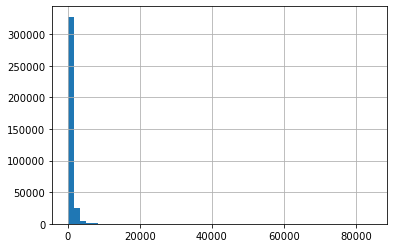

In [24]:
# построим график распределения продолжительности сессий
visits_new['session_duration_sec'].hist(bins=50)
plt.show()

Из гистограммы видим, что распределение далеко от гауссовского. В данном случае для получения среднего значениея предпочтительнее использовать моду, а не полученное нами ранее среднее значение.

In [25]:
print('Типичная продолжительность сессии пользователя ',visits_new['session_duration_sec'].mode()[0],'сек') 

Типичная продолжительность сессии пользователя  60 сек


#### Вывод

Типичная продолжительность сессии пользователя Яндекс.Афиша за исследуемый период равна 60 сек.

### Retention Rate

Рассчитаем коэффициент удержания пользователей применяя когортный анализ.

Определим когортой пользователей объединенных помесячноо по первому обращению их на сайт сервиса. 

In [26]:
# определим для каждого пользователя дату первого обращения 
first_activity_date = visits.groupby(['uid'])['start_ts'].min()
display(first_activity_date.head())

# переименуем столбец с получеными значениями
first_activity_date.name = 'first_activity_date'

# объединим полученный столбец с информацией о визитах по полю - идентификатору пользователя
visits_first = visits.join(first_activity_date,on='uid')
visits_first.head()

uid
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
313578113262317   2017-09-18 22:49:00
325320750514679   2017-09-30 14:29:00
Name: start_ts, dtype: datetime64[ns]

,device,end_ts,source_id,start_ts,uid,first_activity_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-03-09 20:05:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27 14:06:00


Сформируем когорты пользователей по месяцам первого обращения пользователя на сайт.
Определим месяц каждого обращения, рассчитаем разницу в месяцах между текущим обращением и первым. Добавим эту информацию в таблцу `visits_first`

In [27]:

visits_first['first_visit_month'] = visits_first['first_activity_date'].astype('datetime64[M]')
visits_first['visit_month'] = visits_first['start_ts'].astype('datetime64[M]')


visits_first['cohort_lifetime'] = (visits_first['visit_month'] - visits_first['first_visit_month']) / np.timedelta64(1, 'M')
visits_first['cohort_lifetime'] = visits_first['cohort_lifetime'].round().astype('int')
visits_first.head()

,device,end_ts,source_id,start_ts,uid,first_activity_date,first_visit_month,visit_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-03-09 20:05:00,2018-03-01,2018-05-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27 14:06:00,2017-12-01,2017-12-01,0


In [28]:
# создадим таблицу `cohorts` посчитав количество уникальных пользователей в каждый месяц продолжительности жизни когорты
cohorts = visits_first.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 
cohorts.head()

,first_visit_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


In [29]:
# посчитаем начальное количество уникальных пользователей в каждой когорте
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month', 'uid']]
# переименуем столбец с первоначальным количеством пользователей в каждой когорте
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

initial_users_count

,first_visit_month,cohort_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


In [30]:
# объединим таблицы cohorts и initial_users_count по признаку первого визита на сайт
cohorts = cohorts.merge(initial_users_count,on='first_visit_month')

# рассчитаем и добавим к таблице cohorts коэффициент удержания
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

cohorts.head()

,first_visit_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557


In [31]:
# построим сводную таблицу для просмотра Retention Rate
retention_pivot = cohorts.pivot_table(
            index='first_visit_month',
            columns='cohort_lifetime',
            values='retention',
  #          aggfunc='sum',
)
retention_pivot.info()
retention_pivot.fillna(' ')


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2017-06-01 to 2018-05-01
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       12 non-null     float64
 1   1       11 non-null     float64
 2   2       10 non-null     float64
 3   3       9 non-null      float64
 4   4       8 non-null      float64
 5   5       7 non-null      float64
 6   6       6 non-null      float64
 7   7       5 non-null      float64
 8   8       4 non-null      float64
 9   9       3 non-null      float64
 10  10      2 non-null      float64
 11  11      1 non-null      float64
dtypes: float64(12)
memory usage: 1.2 KB


cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,1.0,0.0786635,0.0537748,0.0613923,0.0685572,0.0714232,0.0610152,0.0577721,0.0523418,0.0508334,0.0406516,0.0449506
2017-07-01,1.0,0.0560883,0.0512938,0.0561644,0.0582192,0.0481735,0.0453577,0.0457382,0.0388128,0.0286149,0.0274734,
2017-08-01,1.0,0.076908,0.0628622,0.062764,0.0500933,0.0440035,0.0363422,0.0394853,0.0278951,0.0260289,,
2017-09-01,1.0,0.0854885,0.069205,0.0507064,0.0393918,0.0378352,0.0358597,0.0241858,0.0228089,,,
2017-10-01,1.0,0.078608,0.0522385,0.0389575,0.0342611,0.0322208,0.0213651,0.0203642,,,,
2017-11-01,1.0,0.078281,0.0441133,0.0386817,0.0337272,0.0234146,0.0217998,,,,,
2017-12-01,1.0,0.0558018,0.0379927,0.0311065,0.0202628,0.0190359,,,,,,
2018-01-01,1.0,0.0597153,0.0393388,0.0249735,0.020244,,,,,,,
2018-02-01,1.0,0.0570798,0.0254539,0.0200928,,,,,,,,


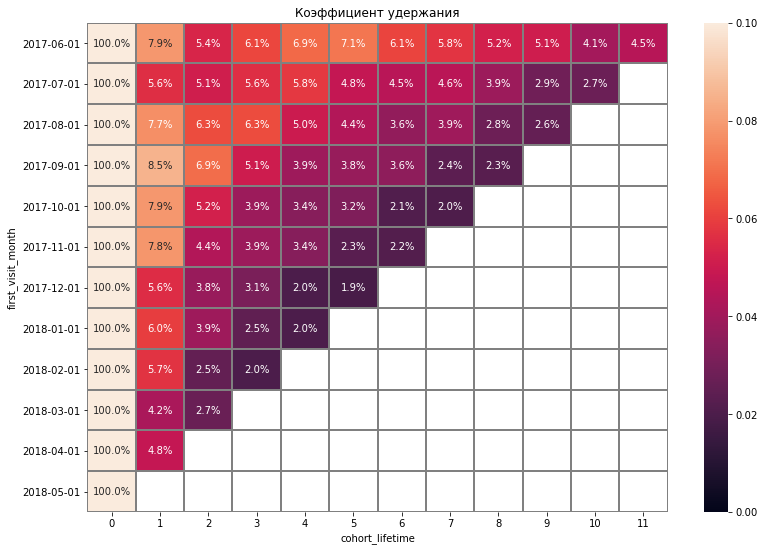

In [32]:
# построим график "тепловую карту" задав лимит 10% для более информативного отображения
plt.figure(figsize=(13, 9))
plt.title('Коэффициент удержания')

retention_pivot.index = retention_pivot.index.astype('str')

sns.heatmap(retention_pivot, annot=True, fmt='.1%',
            vmin= 0, vmax=0.1, 
            linewidths=1, linecolor='gray') 
plt.show()


In [33]:
# рассчитаем средний коэфф удержания на второй месяц 

retention_2_month_mean = retention_pivot[1].mean()
print('Cредний Retention Rate на второй месяц «жизни» когорт {:.2%}'.format(retention_2_month_mean))

Cредний Retention Rate на второй месяц «жизни» когорт 6.52%


#### Вывод

Коэффициент удержания сервиса на следующий месяц после первого обращения составляет от 8.5 до 4.2%. Наблюдается тенденция к снижению Retention Rate как на второй месяц жизни когорты,  так и на протяжении всей жизни каждой когорты.

Cредний Retention Rate на второй месяц «жизни» когорт 6.52%

## Метрики электронной коммерции

### Среднее время от первого посещения до покупки

Исследуем сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. 
Дата и время первого посещения сайта каждым пользователем у нас имеется в таблице `visits`.
Найдем время первой покупки для каждого пользователя. Эту информацию найдем из таблицы `orders`. Затем объединим обе таблицы по полю `uid`

In [34]:
visits.head(10)

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [35]:
# определим для каждого пользователя дату первого визита на сайт
first_visit_date = visits.groupby('uid').agg({'start_ts': 'min'}).reset_index()

first_visit_date = first_visit_date.rename(columns={'start_ts':'first_visit_date'}) 
first_visit_date.head()

,uid,first_visit_date
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [36]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [37]:
# определим для каждого пользователя дату первой покупки
first_order_date = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()

first_order_date = first_order_date.rename(columns={'buy_ts':'first_order_date'}) 
first_order_date.head(10)

,uid,first_order_date
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00
5,3077748354309989,2018-03-03 12:33:00
6,3605148382144603,2017-09-21 20:56:00
7,3753586865891862,2018-03-03 13:50:00
8,4808417689019433,2018-01-09 23:32:00
9,4992223027560440,2018-04-04 13:54:00


In [38]:
# создадим таблицу с датами первого визита и первой покупки каждого купившего пользователя
first_order = first_order_date.merge(first_visit_date,on='uid')

first_order.head()

,uid,first_order_date,first_visit_date
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


In [39]:
# теперь добавим к этой таблице столбец с разницей между первым визитом и покупкой в минутах
first_order['time_for_purchase'] = (first_order['first_order_date'] - first_order['first_visit_date']
                                   ) / np.timedelta64(1, 'm')

first_order.head(10)

,uid,first_order_date,first_visit_date,time_for_purchase
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,154022.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,79.0
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0
5,3077748354309989,2018-03-03 12:33:00,2018-03-03 12:08:00,25.0
6,3605148382144603,2017-09-21 20:56:00,2017-08-15 21:54:00,53222.0
7,3753586865891862,2018-03-03 13:50:00,2018-03-03 13:47:00,3.0
8,4808417689019433,2018-01-09 23:32:00,2018-01-09 23:10:00,22.0
9,4992223027560440,2018-04-04 13:54:00,2018-04-04 13:54:00,0.0


In [40]:
# посмотрим основные характеристики столбца с данными
first_order['time_for_purchase'].describe()

count     36522.000000
mean      24340.842205
std       67785.583078
min           0.000000
25%           4.000000
50%          16.000000
75%        2897.500000
max      523144.000000
Name: time_for_purchase, dtype: float64

Видим колоссальную разницу между мин и макс значениями, кроме того размер стандартного отклонения и медианы показывает, что среднее значение использовать в данном случае невозможно т.к. их распределение сильно смещено от среднего.

Посмотрим гистограмму распределения продолжительности времени между входом на сайт и покупкой.

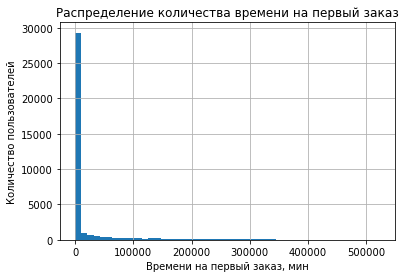

In [41]:
# построим график распределения разницы времени между первым входом на сайт и первым оформлением заказа
first_order['time_for_purchase'].hist(bins=50)
plt.title('Распределение количества времени на первый заказ')
plt.xlabel('Времени на первый заказ, мин')
plt.ylabel('Количество пользователей')
plt.show()

Из гистограммы видим, что распределение сильно смещено. В данном случае для получения среднего значениея предпочтительнее использовать медиану или моду, а не полученное нами ранее среднее значение.

In [42]:
# получим среднее значение столбца time_for_purchase
time_for_order = first_order['time_for_purchase'].mode()

print('Наиболее частое количество времени на первый заказ пользователя, мин  ', time_for_order[0])

null_time_for_order = first_order.query('time_for_purchase == 0')['uid'].count()
print('При этом количество пользователей, которые потратили 0 сек на оформление заказа -  ', null_time_for_order)

Наиболее частое количество времени на первый заказ пользователя, мин   1.0
При этом количество пользователей, которые потратили 0 сек на оформление заказа -   2455


### Cреднее количество покупок на одного покупателя за 6 месяцев

Для расчета среднего количества покупок на покупателя воспользуемся ранее полученной таблицей `first_order_date`. 

Построим месячные когорты на основе даты первой покупки. Затем посчитаем количество покупателей и заказов.

In [43]:
# дополним таблицу с заказами датами первого заказа
orders_new = orders.merge(first_order_date,on='uid')

# дополним таблицу месяцами заказа
orders_new['first_order_month'] = orders_new['first_order_date'].astype('datetime64[M]')
orders_new['order_month'] = orders_new['buy_ts'].astype('datetime64[M]')

orders_new.head()

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


In [44]:
# сгруппируем количестово заказов по когортам и посчитаем количество уникальных покупателей
orders_cohorts = orders_new.groupby(['first_order_month','order_month']
                                   ).agg(({'revenue': 'count', 'uid': 'nunique'})
                                   ).reset_index()
# переименуем столбцы
orders_cohorts.rename(columns={'revenue':'n_orders','uid':'n_buyers'},inplace=True)

# рассчитаем и добавим в таблицу продолжительность жизни когорт в месяцах
orders_cohorts['lifetime'] = (orders_cohorts['order_month'] - orders_cohorts['first_order_month'])/np.timedelta64(1, 'M')
orders_cohorts['lifetime'] = orders_cohorts['lifetime'].round().astype('int')


orders_cohorts.head()

,first_order_month,order_month,n_orders,n_buyers,lifetime
0,2017-06-01,2017-06-01,2354,2023,0
1,2017-06-01,2017-07-01,177,61,1
2,2017-06-01,2017-08-01,174,50,2
3,2017-06-01,2017-09-01,226,54,3
4,2017-06-01,2017-10-01,292,88,4


In [45]:
# выделим и добавим к каждому заказу первоначальное количество пользователей в когорте
initial_users_count = orders_cohorts[orders_cohorts['lifetime'] == 0][['first_order_month', 'n_buyers']]
initial_users_count = initial_users_count.rename(columns={'n_buyers':'first_n_buyers'})

orders_cohorts_all = orders_cohorts.merge(initial_users_count, on='first_order_month')

# рассчитаем и добавим в таблицу количество заказов на одного покупателя когорты
orders_cohorts_all['orders_per_buyer'] = (orders_cohorts_all['n_orders'] / orders_cohorts_all['first_n_buyers']).round(2)

orders_cohorts_all.head()

,first_order_month,order_month,n_orders,n_buyers,lifetime,first_n_buyers,orders_per_buyer
0,2017-06-01,2017-06-01,2354,2023,0,2023,1.16
1,2017-06-01,2017-07-01,177,61,1,2023,0.09
2,2017-06-01,2017-08-01,174,50,2,2023,0.09
3,2017-06-01,2017-09-01,226,54,3,2023,0.11
4,2017-06-01,2017-10-01,292,88,4,2023,0.14


In [46]:
# построим сводную таблицу и выведем в нее количество заказов на одного покупателя на продолжении жизни когорт
revenue_per_user_pivot = orders_cohorts_all.pivot_table(index='first_order_month',
                                                columns='lifetime',
                                                values='orders_per_buyer',
                                                aggfunc='mean'
)
# пересчитаем вывод нарастающим итогом
revenue_per_user_pivot = revenue_per_user_pivot.cumsum(axis=1).round(2)

revenue_per_user_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.70,1.84,1.93,2.03,2.11,2.16,2.2
2017-07-01,1.14,1.19,1.25,1.30,1.34,1.38,1.41,1.44,1.47,1.48,1.51,NaN
2017-08-01,1.12,1.20,1.27,1.33,1.39,1.44,1.48,1.54,1.57,1.60,NaN,NaN
2017-09-01,1.14,1.22,1.28,1.34,1.37,1.41,1.45,1.47,1.49,NaN,NaN,NaN
2017-10-01,1.14,1.21,1.25,1.28,1.31,1.33,1.35,1.38,NaN,NaN,NaN,NaN
2017-11-01,1.18,1.28,1.32,1.37,1.40,1.41,1.43,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.15,1.21,1.26,1.30,1.32,1.34,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.12,1.19,1.24,1.26,1.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.12,1.18,1.20,1.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# получим среднее значение количества заказов на одного пользователя за шесть месяцев по всем когортам
mean_orders_6 = round(revenue_per_user_pivot[5].mean(),2)
print('Среднее количество заказов на одного пользователя на шестой месяц:  {}'.format(mean_orders_6))

Среднее количество заказов на одного пользователя на шестой месяц:  1.43


### Cредний чек

Рассчитаем теперь средний чек заказов на сервисе. Воспользуемся для этого таблицей `orders_new` сгруппировав выручку и количество совершенных покупкок по месяцам.

In [48]:
orders_grouped_by_monthes = orders_new.groupby('order_month'
                                                       ).agg({'revenue': 'sum', 'uid': 'count'}
                                                       ).reset_index()
# переименуем столбцы
orders_grouped_by_monthes.rename(columns={'revenue':'month_revenue', 'uid':'n_orders'},inplace=True)

# рассчитаем средний чек в целом по проекту
total_revenue = orders['revenue'].sum()
total_orders = orders.shape[0]
total_revenue_per_order = total_revenue / total_orders 

# рассчитаем столбец со средним чеком по месяцам
orders_grouped_by_monthes['revenue_per_order'] = ( 
    orders_grouped_by_monthes['month_revenue'] / orders_grouped_by_monthes['n_orders']).round(2)

orders_grouped_by_monthes

,order_month,month_revenue,n_orders,revenue_per_order
0,2017-06-01,9557.49,2354,4.06
1,2017-07-01,12539.47,2363,5.31
2,2017-08-01,8758.78,1807,4.85
3,2017-09-01,18345.51,3387,5.42
4,2017-10-01,27987.70,5679,4.93
5,2017-11-01,27069.93,5659,4.78
6,2017-12-01,36388.60,6218,5.85
7,2018-01-01,19417.13,4721,4.11
8,2018-02-01,25560.54,5281,4.84
9,2018-03-01,28834.59,5326,5.41


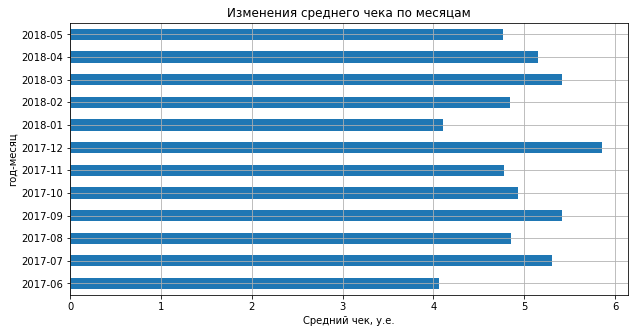

In [49]:
# диаграмма изменения среднего чека

orders_grouped_by_monthes['order_month'] = orders_grouped_by_monthes['order_month'].dt.strftime('%Y-%m')  # для подписи оси y

revenue_plot = orders_grouped_by_monthes.plot(x='order_month', y='revenue_per_order', kind='barh', figsize=(10, 5),
                 grid=True, legend=None
                 )

revenue_plot.set(title='Изменения среднего чека по месяцам',
xlabel = 'Средний чек, у.е.', ylabel='год-месяц')
plt.show()

In [50]:
# минимальное значение среднего чека за месяц
orders_grouped_by_monthes['revenue_per_order'].min()

4.06

In [51]:
# отсортируем  значения среднего чека по убыванию
orders_grouped_by_monthes.sort_values('revenue_per_order', ascending=False).head()

,order_month,month_revenue,n_orders,revenue_per_order
6,2017-12,36388.60,6218,5.85
3,2017-09,18345.51,3387,5.42
9,2018-03,28834.59,5326,5.41
1,2017-07,12539.47,2363,5.31
10,2018-04,16858.06,3273,5.15


Наибольший средний чек - в декабре (5.85 у.е.), затем в сентябре (5.42 у.е.) и в марте (5.41 у.е.)

In [52]:
print('Cредний чек одной покупки за весь исследуемый период:  {:.2f} у.е.'.format(total_revenue_per_order.round(2)))

Cредний чек одной покупки за весь исследуемый период:  5.00 у.е.


### LTV на покупателя по когортам

Рассчитаем итоговую сумму за весь "период жизни" от каждого пользователя (LTV) по когортам - месяцам первой покупки пользователя на сайте Я.Афиши. Для этого возьмем полученную ранее таблицу `orders_new`. 

In [53]:
orders_new.head()

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


In [54]:
# сгруппируем покупателей по когортам и посчитаем выручку
orders_cohorts_revenue = orders_new.groupby(['first_order_month','order_month']
                                   ).agg(({'revenue': 'sum', 'uid': 'nunique'})
                                   ).reset_index()
# переименуем столбцы
orders_cohorts_revenue.rename(columns={'revenue':'month_revenue','uid':'n_buyers'},inplace=True)

# рассчитаем и добавим в таблицу продолжительность жизни когорт в месяцах
orders_cohorts_revenue['lifetime'] = ((orders_cohorts_revenue['order_month'] 
                                      - orders_cohorts_revenue['first_order_month'])/np.timedelta64(1, 'M'))
orders_cohorts_revenue['lifetime'] = orders_cohorts_revenue['lifetime'].round().astype('int')


orders_cohorts_revenue.head()

,first_order_month,order_month,month_revenue,n_buyers,lifetime
0,2017-06-01,2017-06-01,9557.49,2023,0
1,2017-06-01,2017-07-01,981.82,61,1
2,2017-06-01,2017-08-01,885.34,50,2
3,2017-06-01,2017-09-01,1931.30,54,3
4,2017-06-01,2017-10-01,2068.58,88,4


Ранее мы получили первоначальное количество пользователей в каждой когорте. Это таблица `initial_users_count`.

In [55]:
initial_users_count.head()

,first_order_month,first_n_buyers
0,2017-06-01,2023
12,2017-07-01,1923
23,2017-08-01,1370
33,2017-09-01,2581
42,2017-10-01,4340


Присоединим эту информацию к нашей таблице с доходом

In [56]:
# добавим к каждому заказу первоначальное количество пользователей в когорте 
report = orders_cohorts_revenue.merge(initial_users_count, on='first_order_month')

# рассчитаем и добавим в таблицу доход на одного покупателя когорты
report['revenue_per_buyer'] = (report['month_revenue'] / report['first_n_buyers']).round(2)

report.head()

,first_order_month,order_month,month_revenue,n_buyers,lifetime,first_n_buyers,revenue_per_buyer
0,2017-06-01,2017-06-01,9557.49,2023,0,2023,4.72
1,2017-06-01,2017-07-01,981.82,61,1,2023,0.49
2,2017-06-01,2017-08-01,885.34,50,2,2023,0.44
3,2017-06-01,2017-09-01,1931.30,54,3,2023,0.95
4,2017-06-01,2017-10-01,2068.58,88,4,2023,1.02


Показатель LTV рассчитывается из валовой прибыли. По условию маржинальность сервиса составляет 100%. Следовательно валовая прибыль равна выручке. 
Дополним таблицу `report`, полями с валовой прибылью и "возрастом" пользователя на сервисе в месяцах (возрастом когорты)

In [57]:
# маржинальность сервиса
margin_rate = 1.0

# столбец с валовой прибылью
report['gp'] = report['month_revenue'] * margin_rate

report.head() 


,first_order_month,order_month,month_revenue,n_buyers,lifetime,first_n_buyers,revenue_per_buyer,gp
0,2017-06-01,2017-06-01,9557.49,2023,0,2023,4.72,9557.49
1,2017-06-01,2017-07-01,981.82,61,1,2023,0.49,981.82
2,2017-06-01,2017-08-01,885.34,50,2,2023,0.44,885.34
3,2017-06-01,2017-09-01,1931.30,54,3,2023,0.95,1931.30
4,2017-06-01,2017-10-01,2068.58,88,4,2023,1.02,2068.58


In [58]:
# рассчитаем LTV на одного пользователя для каждого месяца "жизни" когорты
report['ltv'] = (report['gp'] / report['first_n_buyers']).round(2)
report.head()

,first_order_month,order_month,month_revenue,n_buyers,lifetime,first_n_buyers,revenue_per_buyer,gp,ltv
0,2017-06-01,2017-06-01,9557.49,2023,0,2023,4.72,9557.49,4.72
1,2017-06-01,2017-07-01,981.82,61,1,2023,0.49,981.82,0.49
2,2017-06-01,2017-08-01,885.34,50,2,2023,0.44,885.34,0.44
3,2017-06-01,2017-09-01,1931.30,54,3,2023,0.95,1931.30,0.95
4,2017-06-01,2017-10-01,2068.58,88,4,2023,1.02,2068.58,1.02


In [59]:
# получим сводную таблицу с LTV по возрасту жизни когорты
output = report.pivot_table(index='first_order_month', 
                            columns='lifetime', 
                            values='ltv', 
                            aggfunc='mean'
                            )

# посчитаем LTV нарастающим итогом
output = output.cumsum(axis=1).round(2)

output

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.40,NaN
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.37,7.58,7.99,8.28,8.47,NaN,NaN
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,NaN,NaN,NaN
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.74,5.00,5.93,7.00,7.31,7.65,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.14,4.43,4.73,4.87,4.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.16,4.44,4.52,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
# посчитаем средний LTV по всем когортам за 6 мес
ltv_mean_6 = output[5].mean()
print('Cредний LTV на одного пользователя по всем когортам за 6 мес   {:.2f} у.е.'.format(ltv_mean_6))

Cредний LTV на одного пользователя по всем когортам за 6 мес   7.97 у.е.


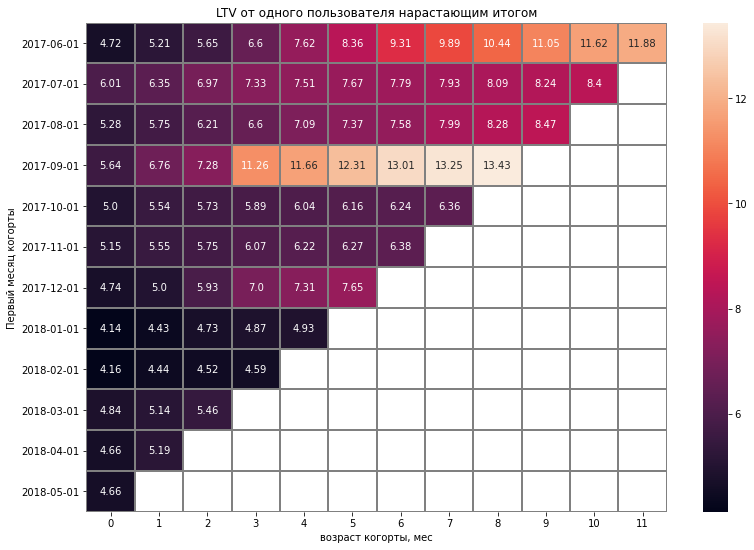

In [61]:
# построим график - "тепловую карту" 
plt.figure(figsize=(13, 9))
plt.title('LTV от одного пользователя нарастающим итогом')

output.index = output.index.astype('str') # подписи оси у

plt_ltv = sns.heatmap(output, annot=True, fmt='',
            linewidths=1, linecolor='gray') 

plt_ltv.set_xlabel('возраст когорты, мес')
plt_ltv.set_ylabel('Первый месяц когорты')

plt.show()

Как видим из графика, наиболее успешная когорта - сентябрьская. На четвертый месяц она практически достигла результата июньской за 11 месяцев.

#### Вывод

Cреднее количество времени на первый заказ пользователя 17 сут, при том, что за год 2455 пользователей затратили 0 сек на совершение заказа (вероятно автоматический заказ из иного сервиса)

Среднее количество заказов на одного пользователя на шестой месяц:  1.43

Cредний чек одной покупки за весь исследуемый период:  5.00 у.е. Наибольший средний чек - в декабре (5.85 у.е.), затем в сентябре (5.42 у.е.) и в марте (5.41 у.е.) Минимальный чек - в июне (4.06 у.е.)

Cредний LTV на одного пользователя по всем когортам за 6 мес   7.97 у.е.

Наибольший доход за исследуемый период принесли пользователи сентябрьской (13.43 у.е.) и июньской (11.88 у.е.) когорт.

## Расходы на маркетинг 

### Общие расходы и распределение расходов по источникам

Для подсчета расходов на маркетинг воспользуемся информацией из таблицы `costs`. Рассчитаем сначала общую сумму расходов, затем ее распределение по месяцам и рекламным источникам. 

In [62]:
# смотрим таблицу
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [63]:
# считаем общую сумму расходов на маркетинг
total_costs = costs['costs'].sum()
print('Общая сумма расходов на маркетинг составляет {:.2f} у.е.'.format(total_costs))

Общая сумма расходов на маркетинг составляет 329131.62 у.е.


In [64]:
# сгруппируем расходы по рекламным источникам
costs_by_source = costs.groupby(['source_id']).agg({'costs': 'sum'}).reset_index()
print('Распределение расходов по рекламным источникам, у.е.:')
costs_by_source

Распределение расходов по рекламным источникам, у.е.:


,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [65]:
# дополним таблицу  месяцем расходов

costs['month'] = costs['dt'].astype('datetime64[M]')
costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [66]:
# построим сводную таблицу для маркетинговых расходов по месяцам и  рекламным источникам 
costs_by_dt = costs.pivot_table(index = 'month',
                                columns = 'source_id',
                                values = 'costs',
                                aggfunc = 'sum').reset_index()

costs_by_dt

source_id,month,1,2,3,4,5,9,10
0,2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
1,2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2,2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
3,2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
4,2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
5,2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
6,2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
7,2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
8,2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88
9,2018-03-01,1893.09,3943.14,13080.85,5961.87,4529.62,480.29,526.41


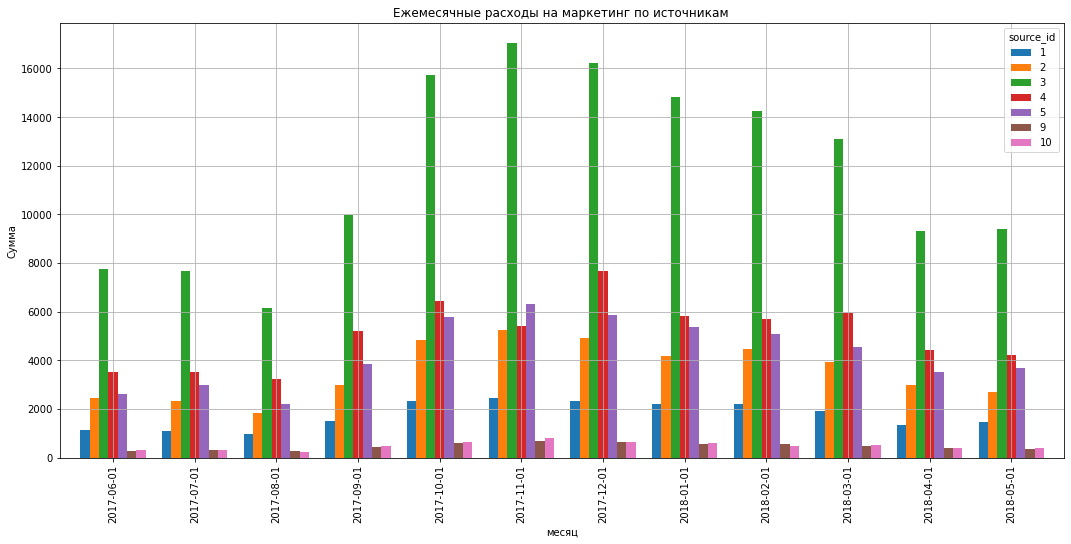

In [67]:
# визуализируем полученные данные по расходам
costs_by_dt['month'] = costs_by_dt['month'].astype('str')   # преобразуем для подписи оси х

source_plot = costs_by_dt.plot(x='month', y=[1, 2, 3, 4, 5, 9, 10], kind='bar',
                 grid=True, figsize=(18, 8), width = 0.8
                 )

source_plot.set(title='Ежемесячные расходы на маркетинг по источникам ',
xlabel = 'месяц', ylabel='Сумма')
plt.show()

#### Вывод

1. Общая сумма расходов на маркетинг составляет 329131.62 у.е.

2. Распределение расходов по рекламным источникам, у.е.:<br>

<table align="centre" width="20%">
           <tr> 
            <th>id источника</th>
            <th>Расходы</th>
           </tr>
            <tr><td>1</td> <td>20833.27</td></tr>
            <tr><td>2</td> <td>42806.04</td></tr>
            <tr><td>3</td> <td>141321.63</td></tr>
            <tr><td>4</td> <td>61073.60</td></tr>
            <tr><td>5</td> <td>51757.10</td></tr>
            <tr><td>9</td> <td>5517.49</td></tr>
           <tr><td>10</td> <td>5822.49</td></tr>
</table>
        
3. Как видим из таблицы и графика наиболее затратный источник - 3, на втором месте (кроме ноября'2017) - 4,на третьем месте - источник номер 5. 

### Средний CAC на одного покупателя

Рассчитаем среднюю стоимость привлечения клиента (CAC) для всего проекта и для каждого источника трафика. <br> В таблице `costs` у нас есть расходы с указанием месяца расхода и рекламного источника. 

Для получения информации об источнике с которого пользователь впервые обратился  к сервису воспользуемся таблицей `visits`

In [68]:
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [69]:
# выделяем информацию о визитах и их источниках
visits_by_source = visits[['uid','source_id','start_ts']].copy()

visits_by_source.head()

,uid,source_id,start_ts
0,16879256277535980062,4,2017-12-20 17:20:00
1,104060357244891740,2,2018-02-19 16:53:00
2,7459035603376831527,5,2017-07-01 01:54:00
3,16174680259334210214,9,2018-05-20 10:59:00
4,9969694820036681168,3,2017-12-27 14:06:00


In [70]:
# находим дату первого визита и рекламный источник визита
first_visit_source = visits_by_source.sort_values('start_ts').groupby('uid').first().reset_index()
first_visit_source.rename(columns={'start_ts':'first_dt'},inplace=True)
first_visit_source.head()

,uid,source_id,first_dt
0,11863502262781,3,2018-03-01 17:27:00
1,49537067089222,2,2018-02-06 15:55:00
2,297729379853735,3,2017-06-07 18:47:00
3,313578113262317,2,2017-09-18 22:49:00
4,325320750514679,5,2017-09-30 14:29:00


Из таблицы заказов `orders`найдем аналогично дату первого заказа пользователя

In [71]:
# таблица заказов
display(orders.head())

# находим даты первого заказа
first_order = orders.sort_values('buy_ts').groupby('uid').first().reset_index()
first_order.rename(columns={'buy_ts':'first_buy_dt'},inplace=True)

first_order.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


,uid,first_buy_dt,revenue
0,313578113262317,2018-01-03 21:51:00,0.55
1,1575281904278712,2017-06-03 10:13:00,1.22
2,2429014661409475,2017-10-11 18:33:00,73.33
3,2464366381792757,2018-01-28 15:54:00,2.44
4,2551852515556206,2017-11-24 10:14:00,6.32


In [72]:
# объединим по uid таблицы с данными о первых визитах и первых заказах

new_orders = first_visit_source.merge(first_order,on='uid')

# преобразуем даты первого визита и заказов
new_orders['first_visit_dt'] = pd.to_datetime(new_orders['first_dt']).dt.date
new_orders['first_order_dt'] = pd.to_datetime(new_orders['first_buy_dt']).dt.date

new_orders.info()
new_orders.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36522 entries, 0 to 36521
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   uid             36522 non-null  uint64        
 1   source_id       36522 non-null  int64         
 2   first_dt        36522 non-null  datetime64[ns]
 3   first_buy_dt    36522 non-null  datetime64[ns]
 4   revenue         36522 non-null  float64       
 5   first_visit_dt  36522 non-null  object        
 6   first_order_dt  36522 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(2), uint64(1)
memory usage: 2.2+ MB


,uid,source_id,first_dt,first_buy_dt,revenue,first_visit_dt,first_order_dt
0,313578113262317,2,2017-09-18 22:49:00,2018-01-03 21:51:00,0.55,2017-09-18,2018-01-03
1,1575281904278712,10,2017-06-03 10:13:00,2017-06-03 10:13:00,1.22,2017-06-03,2017-06-03
2,2429014661409475,3,2017-10-11 17:14:00,2017-10-11 18:33:00,73.33,2017-10-11,2017-10-11
3,2464366381792757,5,2018-01-27 20:10:00,2018-01-28 15:54:00,2.44,2018-01-27,2018-01-28
4,2551852515556206,5,2017-11-24 10:14:00,2017-11-24 10:14:00,6.32,2017-11-24,2017-11-24


In [73]:
# сгруппируем покупателей по источникам и первой дате покупки пользователя
users_by_source = new_orders.groupby(['source_id','first_order_dt']
                                    ).agg({'uid': 'count'}).reset_index()
users_by_source.rename(columns={'uid':'n_users'},inplace=True)
users_by_source.head()

,source_id,first_order_dt,n_users
0,1,2017-06-01,14
1,1,2017-06-02,7
2,1,2017-06-03,7
3,1,2017-06-04,3
4,1,2017-06-05,18


In [74]:
# объединим таблицу users_by_source с таблицей costs с расходами по рекламным источникам и первой дате
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
report = users_by_source.merge(costs, left_on =['source_id','first_order_dt'],right_on =['source_id','dt'] )
report.head()

,source_id,first_order_dt,n_users,dt,costs,month
0,1,2017-06-01,14,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,7,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,7,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,3,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,18,2017-06-05,57.08,2017-06-01


In [75]:
# сгруппируем по источникам и посчитаем общую сумму расходов
report_by_sources = report.groupby(['source_id','first_order_dt','n_users']
                                 ).agg({'costs':'sum'}).reset_index()
report_by_sources.head()

,source_id,first_order_dt,n_users,costs
0,1,2017-06-01,14,75.20
1,1,2017-06-02,7,62.25
2,1,2017-06-03,7,36.53
3,1,2017-06-04,3,55.00
4,1,2017-06-05,18,57.08


In [76]:
# рассчитаем столбец с САС
report_by_sources['cac'] = (report_by_sources['costs'] / report_by_sources['n_users']).round(2)
report_by_sources


,source_id,first_order_dt,n_users,costs,cac
0,1,2017-06-01,14,75.20,5.37
1,1,2017-06-02,7,62.25,8.89
2,1,2017-06-03,7,36.53,5.22
3,1,2017-06-04,3,55.00,18.33
4,1,2017-06-05,18,57.08,3.17
...,...,...,...,...,...
2428,10,2018-05-27,2,9.92,4.96
2429,10,2018-05-28,10,21.26,2.13
2430,10,2018-05-29,7,11.32,1.62
2431,10,2018-05-30,5,33.15,6.63


Получим стоимость привлечения клиента по каждому источнику и по сервису вцелом, сгруппировав таблицу по источникам и усреднив значения 

In [77]:
# сгруппируем таблицу по источникам и усредним САС
report_by_cac = report_by_sources.groupby(['source_id']
                                 ).agg({'cac':'mean'}).round(2).reset_index()

print('Средняя стоимость привлечения одного клиента по рекламным источникам, у.е.')

display(report_by_cac)

print('Средняя стоимость привлечения одного клиента по сервису в целом  {:.2f} у.е.'
      .format(report_by_sources['costs'].sum() / report_by_sources['n_users'].sum()))

Средняя стоимость привлечения одного клиента по рекламным источникам, у.е.


,source_id,cac
0,1,9.49
1,2,16.29
2,3,15.58
3,4,7.27
4,5,8.34
5,9,6.84
6,10,6.56


Средняя стоимость привлечения одного клиента по сервису в целом  8.98 у.е.


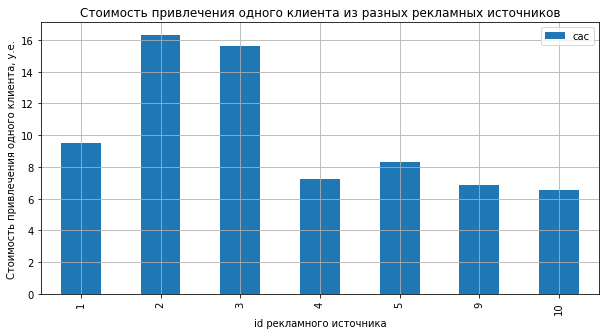

In [78]:
# построим диаграмму
cac_plot = report_by_cac.plot(x='source_id', y='cac', kind='bar', figsize=(10, 5),
                 grid=True
                 )
cac_plot.set(title='Стоимость привлечения одного клиента из разных рекламных источников',
xlabel = 'id рекламного источника', ylabel='Стоимость привлечения одного клиента, у.е.')
plt.show()

#### Вывод

Самая высокая средняя стоимость привлечения клиента (CAC) у рекламных источников 2 и 3.

### ROMI по когортам в разрезе источников

Для расчета ROMI необходимо предварительно расчитать LTV и CAC в разрезе источников.

Т.к. пользователь мог переходить на сервис из разных рекламных источников, примем за основной источник тот, с которого пользователь вошел впервые.

In [79]:
# определим когда и с какого рекламного источника пользователь перешел в сервис в первый раз
first_visit_source = visits.sort_values(by='start_ts').groupby('uid').first().reset_index()
first_visit_source.head()

,uid,device,end_ts,source_id,start_ts
0,11863502262781,touch,2018-03-01 17:33:00,3,2018-03-01 17:27:00
1,49537067089222,touch,2018-02-06 15:57:00,2,2018-02-06 15:55:00
2,297729379853735,desktop,2017-06-07 18:48:00,3,2017-06-07 18:47:00
3,313578113262317,desktop,2017-09-18 23:07:00,2,2017-09-18 22:49:00
4,325320750514679,desktop,2017-09-30 14:38:00,5,2017-09-30 14:29:00


In [80]:
# присоединим к этой таблице информацию о заказах каждого пользователя
visit_for_orders = first_visit_source.merge(orders, on='uid')

# выделим месяцы из дат
visit_for_orders['first_month'] = visit_for_orders['start_ts'].astype('datetime64[M]')
visit_for_orders['month'] = visit_for_orders['buy_ts'].astype('datetime64[M]')

visit_for_orders.head()

,uid,device,end_ts,source_id,start_ts,buy_ts,revenue,first_month,month
0,313578113262317,desktop,2017-09-18 23:07:00,2,2017-09-18 22:49:00,2018-01-03 21:51:00,0.55,2017-09-01,2018-01-01
1,1575281904278712,touch,2017-06-03 10:17:00,10,2017-06-03 10:13:00,2017-06-03 10:13:00,1.22,2017-06-01,2017-06-01
2,1575281904278712,touch,2017-06-03 10:17:00,10,2017-06-03 10:13:00,2017-06-03 17:39:00,1.83,2017-06-01,2017-06-01
3,2429014661409475,desktop,2017-10-11 17:27:00,3,2017-10-11 17:14:00,2017-10-11 18:33:00,73.33,2017-10-01,2017-10-01
4,2464366381792757,desktop,2018-01-27 20:13:00,5,2018-01-27 20:10:00,2018-01-28 15:54:00,2.44,2018-01-01,2018-01-01


In [81]:
# рассчитаем по источникам и месяцам количество покупателей в месяц и сумму заказа
orders_by_source = visit_for_orders.groupby(['source_id','first_month','month']
                                           ).agg({'uid':'nunique','revenue':'sum'}).reset_index()
orders_by_source

,source_id,first_month,month,uid,revenue
0,1,2017-06-01,2017-06-01,190,1378.70
1,1,2017-06-01,2017-07-01,29,662.73
2,1,2017-06-01,2017-08-01,20,683.12
3,1,2017-06-01,2017-09-01,22,1613.45
4,1,2017-06-01,2017-10-01,19,1055.58
...,...,...,...,...,...
534,10,2018-03-01,2018-04-01,11,22.42
535,10,2018-03-01,2018-05-01,3,7.62
536,10,2018-04-01,2018-04-01,94,237.44
537,10,2018-04-01,2018-05-01,4,21.26


In [82]:
costs_by_sources = costs.groupby(['month','source_id']).agg({'costs':'sum'}).reset_index()
costs_by_sources.head()

,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


In [83]:
# объединим данные о доходах, расходах 
union_data = orders_by_source.merge(costs_by_sources, on=['source_id','month'])

# рассчитаем LTV и САС, затем ROMI
union_data['ltv'] = union_data['revenue'] / union_data['uid']
union_data['cac'] = union_data['costs'] / union_data['uid']
union_data['romi'] = union_data['ltv'] / union_data['cac']

# определим продолжительность жизни каждой когорты
union_data['life_time'] = (union_data['month'] - union_data['first_month'])/ np.timedelta64(1, 'M')
union_data['life_time'] = union_data['life_time'].round().astype('int')

union_data.head(10)

,source_id,first_month,month,uid,revenue,costs,ltv,cac,romi,life_time
0,1,2017-06-01,2017-06-01,190,1378.70,1125.61,7.256316,5.924263,1.224847,0
1,1,2017-06-01,2017-07-01,29,662.73,1072.88,22.852759,36.995862,0.617711,1
2,1,2017-07-01,2017-07-01,147,918.95,1072.88,6.251361,7.298503,0.856526,0
3,1,2017-06-01,2017-08-01,20,683.12,951.81,34.156000,47.590500,0.717706,2
4,1,2017-07-01,2017-08-01,8,131.13,951.81,16.391250,118.976250,0.137769,1
5,1,2017-08-01,2017-08-01,100,627.24,951.81,6.272400,9.518100,0.658997,0
6,1,2017-06-01,2017-09-01,22,1613.45,1502.01,73.338636,68.273182,1.074194,3
7,1,2017-07-01,2017-09-01,12,210.49,1502.01,17.540833,125.167500,0.140139,2
8,1,2017-08-01,2017-09-01,16,121.66,1502.01,7.603750,93.875625,0.080998,1
9,1,2017-09-01,2017-09-01,205,1126.01,1502.01,5.492732,7.326878,0.749669,0


In [84]:
# форматирование даты для подписей на графике
union_data['first_month'] = union_data['first_month'].astype('str')
union_data['first_month'] = union_data.first_month.str.rjust(15,' ')

In [85]:
# составим сводную таблицу для простмотра взаимосвязи рекламных источников, 
# "времени жизни" когорт пользователей и ROMI
pivot_source = union_data.pivot_table(index = ['source_id','first_month'],
                                     columns = 'life_time',
                                     values = 'romi',
                                     aggfunc = 'mean'
                                     )
pivot_source = pivot_source.cumsum(axis=1).round(2) 
pivot_source

life_time                    0     1     2     3     4     5     6     7   \
source_id first_month                                                       
1              2017-06-01  1.22  1.84  2.56  3.63  4.09  4.34  4.62  5.08   
               2017-07-01  0.86  0.99  1.13  1.18  1.22  1.26  1.28  1.35   
               2017-08-01  0.66  0.74  0.79  0.83  0.86  0.89  0.89  1.36   
               2017-09-01  0.75  0.94  1.03  1.15  1.23  1.28  1.30  1.31   
               2017-10-01  0.82  1.04  1.11  1.19  1.25  1.29  1.37  1.48   
               2017-11-01  0.80  0.84  0.88  0.90  0.98  1.00  1.05   NaN   
               2017-12-01  0.59  0.65  0.71  0.87  0.88  0.97   NaN   NaN   
               2018-01-01  0.40  0.44  0.46  0.47  0.49   NaN   NaN   NaN   
               2018-02-01  0.49  0.65  0.66  0.73   NaN   NaN   NaN   NaN   
               2018-03-01  0.78  0.83  0.89   NaN   NaN   NaN   NaN   NaN   
               2018-04-01  0.58  0.61   NaN   NaN   NaN   NaN   NaN   NaN   
               2018-05-01  0.72   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2              2017-06-01  0.43  0.60  0.65  0.99  1.22  1.30  1.45  1.59   
               2017-07-01  0.63  0.79  0.83  0.86  0.91  0.96  0.99  1.01   
               2017-08-01  0.30  0.33  0.33  0.35  0.36  0.37  0.38  0.39   
               2017-09-01  0.41  0.73  0.85  0.88  0.93  0.97  1.00  1.01   
               2017-10-01  0.51  0.79  0.83  0.88  0.91  0.95  0.97  0.99   
               2017-11-01  0.33  0.44  0.55  0.68  0.75  0.82  0.87   NaN   
               2017-12-01  0.56  0.67  1.44  2.49  2.85  3.29   NaN   NaN   
               2018-01-01  0.22  0.30  0.44  0.47  0.50   NaN   NaN   NaN   
               2018-02-01  0.26  0.36  0.40  0.44   NaN   NaN   NaN   NaN   
               2018-03-01  0.32  0.41  0.57   NaN   NaN   NaN   NaN   NaN   
               2018-04-01  0.30  0.38   NaN   NaN   NaN   NaN   NaN   NaN   
               2018-05-01  0.92   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3              2017-06-01  0.36  0.46  0.49  0.53  0.56  0.58  0.59  0.60   
               2017-07-01  0.32  0.35  0.37  0.39  0.40  0.41  0.42  0.43   
               2017-08-01  0.26  0.27  0.29  0.30  0.30  0.31  0.31  0.32   
               2017-09-01  0.39  0.44  0.47  0.48  0.50  0.51  0.54  0.54   
               2017-10-01  0.28  0.33  0.35  0.36  0.38  0.40  0.41  0.42   
               2017-11-01  0.27  0.30  0.32  0.34  0.37  0.38  0.40   NaN   
               2017-12-01  0.28  0.31  0.33  0.34  0.36  0.38   NaN   NaN   
               2018-01-01  0.21  0.24  0.26  0.27  0.29   NaN   NaN   NaN   
               2018-02-01  0.22  0.26  0.28  0.32   NaN   NaN   NaN   NaN   
               2018-03-01  0.22  0.25  0.26   NaN   NaN   NaN   NaN   NaN   
               2018-04-01  0.23  0.35   NaN   NaN   NaN   NaN   NaN   NaN   
               2018-05-01  0.23   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4              2017-06-01  0.56  0.65  0.69  0.78  0.89  1.11  1.28  1.32   
               2017-07-01  0.72  0.79  0.82  0.85  0.88  0.90  0.92  0.95   
               2017-08-01  0.46  0.49  0.51  0.55  0.55  0.57  0.59  0.60   
               2017-09-01  0.45  0.54  0.59  0.62  0.64  0.66  0.69  0.69   
               2017-10-01  0.69  0.77  0.82  0.87  0.90  0.94  0.98  1.03   
               2017-11-01  0.90  1.02  1.06  1.11  1.16  1.21  1.25   NaN   
               2017-12-01  0.59  0.65  0.70  0.74  0.77  0.81   NaN   NaN   
               2018-01-01  0.53  0.62  0.65  0.67  0.68   NaN   NaN   NaN   
               2018-02-01  0.59  0.66  0.73  0.77   NaN   NaN   NaN   NaN   
               2018-03-01  0.64  0.70  0.72   NaN   NaN   NaN   NaN   NaN   
               2018-04-01  0.57  0.64   NaN   NaN   NaN   NaN   NaN   NaN   
               2018-05-01  0.60   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
5              2017-06-01  0.73  0.89  1.01  1.11  1.17  1.20  1.28  1.33   
               2017-07-01  0.69  0.78  0.86  0.88  0.90  0.93  0.94  0.97

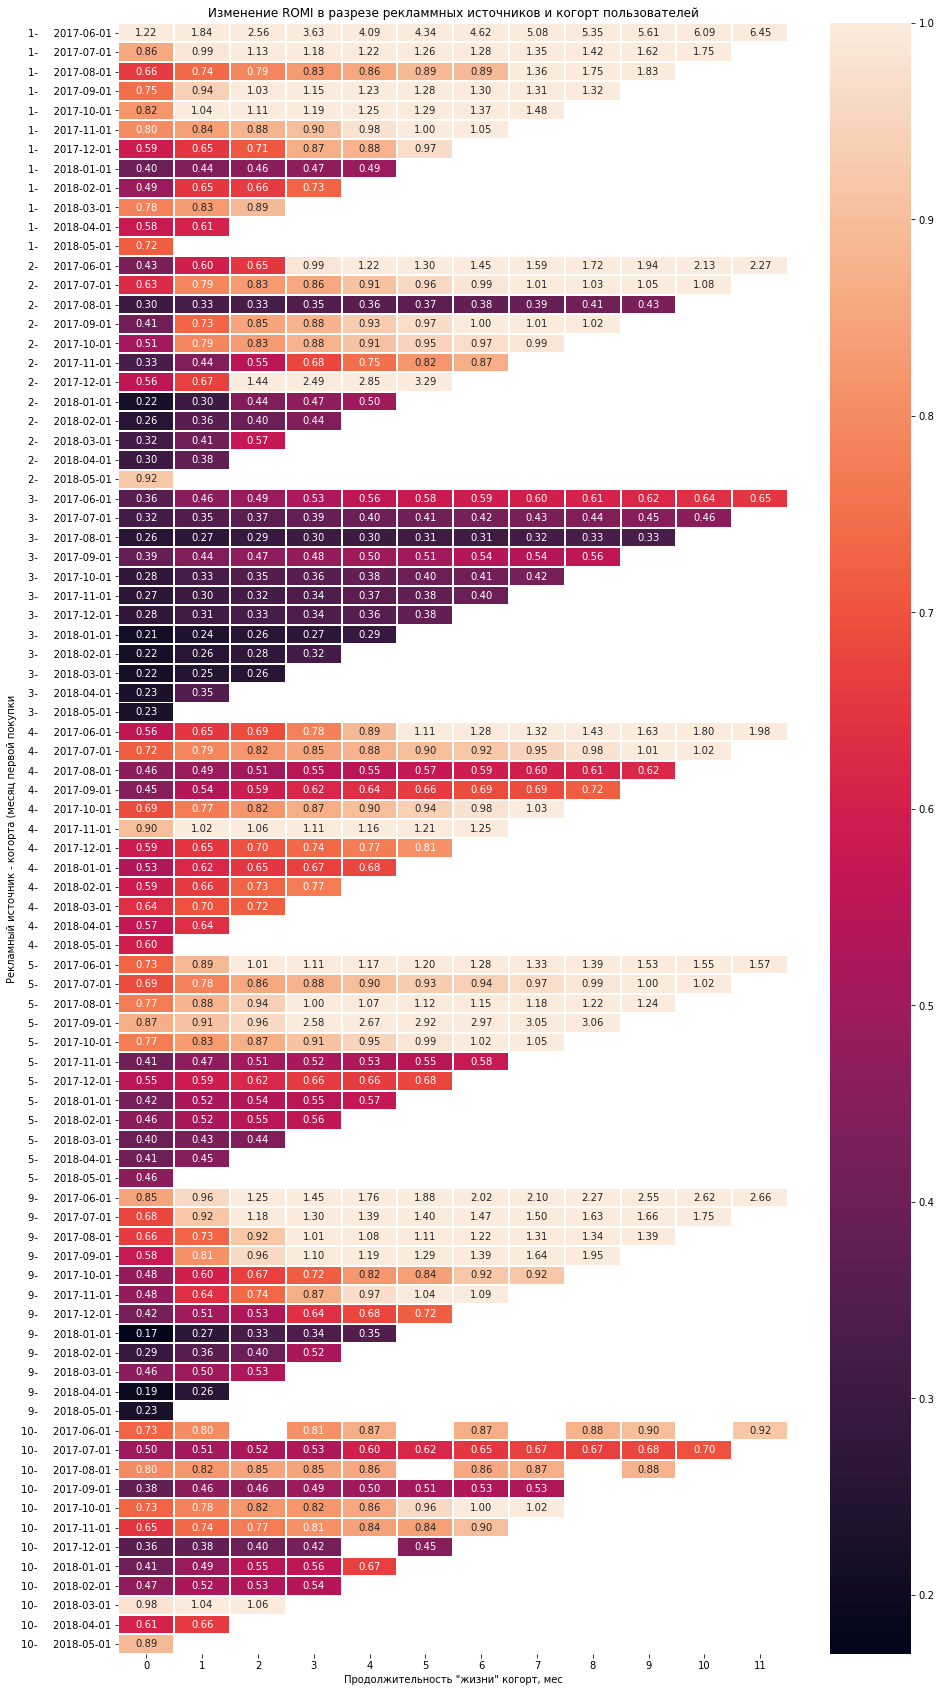

In [86]:
# для наглядности построим график-тепловую карту для полученной таблицы
fig,ax = plt.subplots(figsize=(15, 30))


ax.set_title('Изменение ROMI в разрезе рекламмных источников и когорт пользователей')

ax = sns.heatmap(pivot_source, annot=True, fmt='.2f', vmax=1, linewidths=1,  linecolor='white') 
ax.set_xlabel('Продолжительность "жизни" когорт, мес')
ax.set_ylabel('Рекламный источник - когорта (месяц первой покупки')
    
plt.show()

#### Вывод

Как видим из тепловой карты по источникам и когортам, наилучшее значение возврата маркетинговых инвестиций (ROMI) у рекламного источника с id=1,где инвестиции возвращаются в первый же месяц. за ним следует рекламный источник id=9, и далее id=5.

Наихудший показатель ROMI у источника с id=3.

В целом, обращает на себя внимание ухудшение ROMI по всем источникам и когортам после октября-ноября 2017 года.

### Выводы

 - предоставленные данные не имеют пропусков и дубликатов;
 - наименования столбцов приведены к стандартному виду, преобразованы форматы полей с датами, отсечены данные не входящие в исследуемый период;
 -  из полученных графиков следует,что:
   - в осенне-летний период количество посетителей сайта в 1.5 - 2 раза ниже, чем в весенне-зимний;
   - имеется пик обращений на сайт 24 ноября 2017 года (3319). Возможно планировалось какое-то мероприятие или акция;
   - имеется провал 30 и 31 марта 2018 г, вероятно связанный с недоступностью сервиса.
   
Продуктовые метрики
   - среднее количество уникальных пользователей в день (DAU): 907
   - среднее количество уникальных пользователей в неделю (WAU): 5716
   - среднее количество уникальных пользователей в месяц (MAU): 23227
 - среднее количество входов одного пользователя на сайт в день изменяется достаточно стабильно на протяжении всего периода и в среднем за год это значение равно 1.08;
 - типичная продолжительность сессии пользователя Яндекс.Афиша за исследуемый период равна 60 сек;
 - коэффициент удержания сервиса на следующий месяц после первого обращения составляет от 8.5% до 4.2%. 
 - наблюдается тенденция к снижению Retention Rate как на второй месяц жизни когорты, так и на протяжении всей "жизни" каждой когорты
 
Метрики электронной коммерции
 - среднее количество времени на первый заказ пользователя 17 сут, при том, что за год 2455 пользователей затратили 0 сек на совершение заказа (вероятно автоматический заказ из иного сервиса)
 - среднее количество заказов на одного пользователя на шестой месяц:  1.43
 - средний чек одной покупки за весь исследуемый период:  5.00 у.е. Наибольший средний чек - в декабре (5.85 у.е.), затем в сентябре (5.42 у.е.) и в марте (5.41 у.е.) Минимальный чек - в июне (4.06 у.е.)
 - средний LTV на одного пользователя по всем когортам за 6 мес 7.97 у.е.
 - наибольший доход за исследуемый период принесли пользователи сентябрьской (13.43 у.е. на человека) и июньской (11.88 у.е.) когорт
 
Маркетинговые метрики
 1. Общая сумма расходов на маркетинг составляет 329131.62 у.е.

 2. Распределение расходов по рекламным источникам, у.е.:<br>
 <table align="centre" width="20%">
           <tr> 
            <th>id источника</th>
            <th>Расходы</th>
           </tr>
            <tr><td>1</td> <td>20833.27</td></tr>
            <tr><td>2</td> <td>42806.04</td></tr>
            <tr><td>3</td> <td>141321.63</td></tr>
            <tr><td>4</td> <td>61073.60</td></tr>
            <tr><td>5</td> <td>51757.10</td></tr>
            <tr><td>9</td> <td>5517.49</td></tr>
           <tr><td>10</td> <td>5822.49</td></tr>
</table>
  
 3. Из сводной таблицы и графика следует, что наиболее затратный источник - 3, на втором месте (кроме ноября'2017) - 4,на третьем месте - источник номер 5. 
 4. Самая высокая средняя стоимость привлечения клиента (CAC) у рекламных источников 2 и 3.
 5. Как видим из тепловой карты по источникам и когортам, наилучшее значение возврата маркетинговых инвестиций (ROMI) у рекламного источника с id=1,где инвестиции возвращаются в первый же месяц. за ним следует рекламный источник id=9, и далее id=5. Наихудший показатель ROMI у источника с id=3.

В целом, обращает на себя внимание ухудшение ROMI по всем источникам и когортам после октября-ноября 2017 года.
   

### Рекомендации

1. По результатам исследования представляется наиболее эффективным использовать источники траффика c id 1, 5 и 9. Рекламный источник id=3 представляется крайне не эффективным. Данная рекомендация основана на соотношении метрик CAC и ROMI этих источников.

2. Наиболее прибыльными по всем источникам выглядят когорты пользователей, зарегистрировавшиеся с июня по октябрь 2017 года.

3. Пользователи, зарегистрировавшиеся после октября 2017 года, за некоторыми исключениями (см.график ROMI) заметно хуже возвращают инвестиции. Возможно следует усилить работу с этими когортами.

